## For Development Only 

In [2]:
!which python
import os
print(os.__file__)

/opt/conda/bin/python
/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/os.py


In [3]:
!pwd

/home/abarbour


In [5]:
import skbeam
print(skbeam.__version__)
import csxtools
print(csxtools.__version__)
import pyCHX
print(pyCHX.__version__)
import slicerator
print(slicerator.__version__)
import databroker 
print(databroker.__version__)

0.0.22
0.1.15
4.0.8+0.g2ea7aee.dirty
1.0.0
0.13.0


## Start Here for normal use 

In [6]:
!pwd

/home/abarbour


In [1]:
import numpy as np

from databroker import Broker
db = Broker.named('csx',auto_register =  False)

from csxtools.utils import get_fastccd_images,get_fastccd_flatfield
from csxtools.ipynb import image_stack_to_movie, show_image_stack  # FOUND MOVIE


#import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import pyCHX.chx_correlation as corr
import pyCHX.Two_Time_Correlation_Function as corr2t

import itertools

from tqdm import tqdm  #TODO is this used?
import time

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' #until matplotlib's internal ffmpeg is fixed.

from scipy import ndimage
from scipy import stats

def browse_images(res,title='Frame'):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title(f'{title} {i}')
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))
    
def area_images(fullFOVimages,areas):
    for k in areas.keys():
        temp = np.array(fullFOVimages[:, areas[k]['loc'][0] : areas[k]['loc'][1], areas[k]['loc'][2] : areas[k]['loc'][3]])
        areas[k].update({'data' : temp})

from scipy import polyfit
from scipy.optimize import curve_fit

def single_exp(x, A, tau, offset):
    #return A*np.exp(-2*(x/tau)) + 1 + offset
    return A*np.exp(-1*(x/tau)) + 1 + offset

def KWW_exp(x, A, tau,  beta, offset):
    return A*np.exp(-2*(x/tau)**beta) + 1 + offset


##### SMALL SETUP

sample_details ={}
area_dict = {}
list_areas = []
roi_dict = {}
rois = []   
roi_names = []
autocorr_results = {}
cullit = False

%matplotlib inline

/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
%matplotlib inline
def get_images_final(header, bgnd8, bgnd2=None, bgnd1 = None, flatfieldresult=None):
    if header['start']['num_points'] > 1:
        print('\n\nWarning: This function will collapse all data into one stack - see csxtools: get_images_to_3D, get_images_to_4D\n\n')
    print('Processing scan {}'.format(header['start']['scan_id']))
    stack = get_fastccd_images(header, (bgnd8, bgnd2, bgnd1), flat=flatfieldresult, tag='fccd_image')
    images = stack[0]
    #if images.shape[-1] > 960:    
        #print('images is larger than 960 pixels, first image shape is' , images[0].shape)
        #images = np.concatenate((images[:,:,486:966],images[:,:,1034:1514]),axis=2)
    if images.shape[2]>1400:
        images = np.concatenate((images[:,:,486:966],images[:,:,1034:1514]),axis=2) #TODO, this is extra pix - check JJ data
    elif 1400>images.shape[2]>999:
        images = np.concatenate((images[:,:,7:486],images[:,:,515:997]),axis=2)
    else:
        #print('first image shape is', images[0].shape)
        pass
    return images


def strip_pix_always_nan(imgs,roi_mask):
    vsize, hsize = imgs[0].shape
    temp = np.sum(np.ones((1,vsize,hsize), dtype=np.int64) * (np.isnan(imgs[:]) == False), axis=0) #set NaNs = 0 and sum to find always NaN (=0)
    temp = np.ones((vsize,hsize), dtype=np.int64) * (temp>0)  #make all other pixels 1 except always NaN
    roi_mask = roi_mask * temp
    return roi_mask

### Quick note
Since there is a suspicion that this is real space imaging of diffraction from the surface, then XPCS isn't the best word to describe the analysis.  We should find the electron microscopy word or the IR imaging words that describe autocorrelation of pixel intensity over time.

/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/site-packages/csxtools/utils.py:190: UserWarning: Images and get_images are deprecated. Use Header.data('fccd_image') instead.
  images = header.db.get_images(header, tag)
/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/site-packages/csxtools/utils.py:271: RuntimeWarning: invalid value encountered in greater
  flat[flat > limits[1]] = np.nan
Flatfield correction removed 74325 pixels (7.74 %)


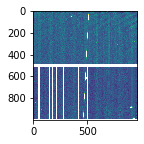

In [3]:
flat_scans = db[127905] 
bgnd1 = db[127904]
bgnd2 = db[127903]
bgnd8 = db[127902]

ff = get_fastccd_flatfield(flat_scans, (bgnd8, bgnd2, bgnd1))#, limits=(0.1, 2)) 

plt.figure(figsize=(2,2))
plt.imshow(ff)

In [4]:
#### PILOT DATA. ###
scan_no = 126360  ; descript = ' 4 um per s'
#scan_no = 126353  ; descript = ' 2 um per s bad at v.end' #fall of sample at end, just
#scan_no = 126404  ; descript = ' 2 um per s'
#scan_no = 126395 ; descript = ' 1 um per s'
#scan_no = 126357  ; descript =  ' 4 um per s  w/ sudden stop'
#scan_no = 126365  ; descript = ' long static test'

h = db[scan_no] # h is for header
descript = 'TbCo' + descript

bgnd1 = None #db[h.start['scan_id']-1]#None #
bgnd2 = None #db[h.start['scan_id']-2]#None #
bgnd8 = db[126362]


tbl=h.table()
tbl_bl = h.table('baseline') # this data table will let you look at positions motors not in the scan
tbl_dark=bgnd8.table()

pixels_in_ADU = True
cullitdone = False
ADUpPH = 30*np.nanmean(tbl_bl.pgm_energy_readback)/930

In [5]:
exposuretime = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time']  # use if ct/s is needed
frametime = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_period'] # use if you want to time slice (XPCS)

print(time.ctime(h.start['time']))
print(h['start']['scan_id'], '\tdata scan number')
print(h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_num_images'], '\tnum img requested')
print(h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time'], '\tacquire time\n')
#print(h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_fcric_gain'], '\tgain_bit\n')

print(tbl_bl.stemp_temp_A_T[1], '  control [K]')
print(tbl_bl.stemp_temp_B_T[1], '  sample [K]\n\n')

print(bgnd8['start']['scan_id'], '\tdark scan number')
print(bgnd8.descriptors[0]['configuration']['fccd']['data']['fccd_cam_num_images'], '\tnum img requested')
print(bgnd8.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time'], '\tacquire time\n')
#print(bgnd8.descriptors[0]['configuration'][]'fccd']['data']['fccd_cam_fcric_gain'], '\tgain_bit\n')

print(frametime,'\t dt for autocorrelation')


Wed Jan 15 12:34:43 2020
126360 	data scan number
200 	num img requested
0.2575 	acquire time

295.623   control [K]
296.281   sample [K]


126362 	dark scan number
50 	num img requested
0.2575 	acquire time

0.3375 	 dt for autocorrelation


In [6]:
## TODO add units 
sample_details = {'beamline': h.start['beamline_id'],
                  'geometry': f'transmission - del, gam = {tbl_bl["tardis_delta"].mean():.1f}, {tbl_bl["tardis_gamma"].mean():.1f}',
                  'sampleT' : {'value': np.round(tbl_bl.stemp_temp_B_T.mean(),2), 'unit':'K'},   #TODO GET UNIT FROM DESCRIPTORS
                  'Ei'      : {'value': tbl_bl.pgm_energy_setpoint.mean(), 'unit':'eV'},        #TODO GET UNIT FROM DESCRIPTORS
                  #'HKL'     : [np.round(tbl_bl[x].mean(),3) for x in ['tardis_h','tardis_k', 'tardis_l']],
                  #'ZP pos'  : tbl_bl.nanop_by.mean(),
                  'pinhole'  : '10 um',                                                          # TODO fix this with IOC, ophyd device and md
                  'purpose' : h.start.get('purpose', ' '),
                  'sample'  : h.start['sample'],
                  'exp_time': np.round(exposuretime,4),
                  'dt'      : frametime,
                  'scan'    : h['start']['scan_id'],
                  'descript' : descript,
                  'img proc': {'darks': (bgnd8['start']['scan_id'], None, None),                 #TODO fix this so generic so no manual decleartion of other dark settings.
                               'flat': flat_scans.get('start', 'None').get('scan_id'),
                               'filters': 'None',
                               'subtract': 'None'},
#                   'img proc': {'darks': (bgnd8['start']['scan_id'], bgnd2.get('start', 'None').get('scan_id', 'None'),bgnd1.get('start', 'None').get('scan_id','None')), 
#                                'flat': flat_scans.get('start', 'None').get('scan_id'),
#                                'filters': 'None',
#                                'subtract': 'None'}
                  }
sample_details

{'beamline': 'CSX-1',
 'geometry': 'transmission - del, gam = 0.2, 6.0',
 'sampleT': {'value': 296.28, 'unit': 'K'},
 'Ei': {'value': 780.2529978, 'unit': 'eV'},
 'pinhole': '10 um',
 'purpose': '10um pinhole 4um p s',
 'sample': {'type': 'pilotXPCS', 'composition': 'TbCo', 'lattice': []},
 'exp_time': 0.2575,
 'dt': 0.3375,
 'scan': 126360,
 'descript': 'TbCo 4 um per s',
 'img proc': {'darks': (126362, None, None),
  'flat': 127905,
  'filters': 'None',
  'subtract': 'None'}}

In [7]:
#%%capture
images = get_images_final(h, bgnd8, bgnd2, bgnd1, flatfieldresult=ff)  #

print(images.shape)
pixels_in_ADU = True

Processing scan 126360


Missing dark image for gain setting 2
Missing dark image for gain setting 1


(200, 960, 961)


In [8]:
mcsdata_time = tbl.fccd_mcs_wfrm_wfrm_1
mcsdata_tey = tbl.fccd_mcs_wfrm_wfrm_4
mcsdata_tfy = tbl.fccd_mcs_wfrm_wfrm_5

mcs_time = []
mcs_tey = []
mcs_tfy = []
#TODO make this pythonista style
for i in range(0,len(mcsdata_tey+1)): 
    mcs_time.append(mcsdata_time[i+1])
    mcs_tey.append(mcsdata_tey[i+1])
    mcs_tfy.append(mcsdata_tfy[i+1])

print(f'FCCD images points = {images.shape[0]}\nMCS time points = {len(mcs_time[0])}\n\tIF not equal, drop first FCCD image as this seems to be the case')#TODO more test

FCCD images points = 200
MCS time points = 199
	IF not equal, drop first FCCD image as this seems to be the case


### Explore data interactively
* with ipython widgets

In [9]:
#%matplotlib widget
#print('getting widget back')

In [10]:
#%matplotlib widget
#print('getting widget back to explore Two-Time')
#print('now explore images')
%matplotlib inline

### Convert to photons 
* we should probably do this in part of the image normalization
* Note that this is an approximation and not calibrated for THIS FCCD

In [11]:
if pixels_in_ADU is True: #TODO, do this before selecting primary areas
    print('Converting images to photons from ADU\n')
    images = images[:] / ADUpPH 
    pixels_in_ADU = False

Converting images to photons from ADU



/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/abarbour/conda_envs/csx-s2-pyCHX/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: All-NaN slice encountered


0 18.589263916015625
APPROXIMATE ADU per photon:			25.2 ADU
Max number photon in 1 image pixel (0.2575s):	390.1 ph
Number photons in 1 image (0.2575s):		13928039.0 ph




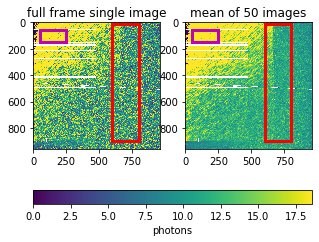

In [82]:
frame_beg = 0
frame_end = 50
avg_frames = np.nanmean(images[frame_beg:frame_end,:,:],axis=0)
floor = 0
ceiling = np.nanmax(images[0])*.05

print(floor, ceiling)

fig, axes = plt.subplots(1,2,figsize=(5,5))
im=axes[0].imshow(images[0], vmin=floor, vmax=ceiling,
                  cmap='viridis', interpolation='none')
axes[0].set_title('full frame single image')
axes[1].imshow(avg_frames, vmin=floor, vmax=ceiling,
               cmap='viridis', interpolation='none')
axes[1].set_title('mean of {} images'.format(images[frame_beg:frame_end,:,:].shape[0]))

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),orientation="horizontal")
if pixels_in_ADU is True:
    cbar.set_label('ADU')
if pixels_in_ADU is False:
    cbar.set_label('photons')

if len(area_dict) > 0:
    for k in area_dict.keys():
        V1, V2, H1, H2 = area_dict[k]['loc']
        rect = patches.Rectangle((H1,V1),(H2-H1),(V2-V1),linewidth=3,edgecolor=area_dict[k]['color'],facecolor='none')
        rect2 = patches.Rectangle((H1,V1),(H2-H1),(V2-V1),linewidth=3,edgecolor=area_dict[k]['color'],facecolor='none')
        axes[0].add_patch(rect)
        axes[1].add_patch(rect2)
        

maxphoton=np.nanmax(np.nanmax(images[1,:,:],axis=1),axis=0)
exposuretime=h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time']
SUMphoton=np.nansum(np.nansum(images[1,:,:],axis=1),axis=0)

print(f'APPROXIMATE ADU per photon:\t\t\t{ADUpPH:2.1f} ADU')
print(f'Max number photon in 1 image pixel ({exposuretime:.4f}s):\t{maxphoton:2.1f} ph')
print(f'Number photons in 1 image ({exposuretime:.4f}s):\t\t{SUMphoton:2.1f} ph\n\n')

### Set Primary Areas(s) below for image above so ROI viewing/assignment for analysis is easier 

In [13]:
#                               V1   V2  H1  H2 # pixel address
area_dict = {'area1' : {'loc': (  10,900,600,800), 'name' : 'xpcs' , 'color':'r'},
             #'area2' : {'loc': (  60,150, 50,250), 'name' : 'ref', 'color':'m'},
             'area2' : {'loc': (  60,150, 50,250), 'name' : 'bkgnd', 'color':'m'},
            }

area_images(images,area_dict)
list_areas = [area_dict[k]['name'] for k in area_dict.keys()]#TODO may not need this anymore
sub_images = area_dict['area1']['data']
#bkg_images = area_dict['area2']['data']
_,vsize,hsize =  area_dict['area1']['data'].shape

print(vsize,hsize,' vertical and horizontal size of sub_images')
if len(area_dict) > 0:
    for k in area_dict.keys():
        V1, V2, H1, H2 = area_dict[k]['loc']
        rect = patches.Rectangle((H1,V1),(H2-H1),(V2-V1),linewidth=3,edgecolor=area_dict[k]['color'],facecolor='none')
        rect2 = patches.Rectangle((H1,V1),(H2-H1),(V2-V1),linewidth=3,edgecolor=area_dict[k]['color'],facecolor='none')
        axes[0].add_patch(rect)
        axes[1].add_patch(rect2)
print('\tScroll up to verify placement of areas')

890 200  vertical and horizontal size of sub_images
	Scroll up to verify placement of areas


APPROXIMATE ADU per photon:			25.2
Max number photon in 1 image (0.2575s):	2.2
Number photons in 1 image (0.2575s):	85728.9




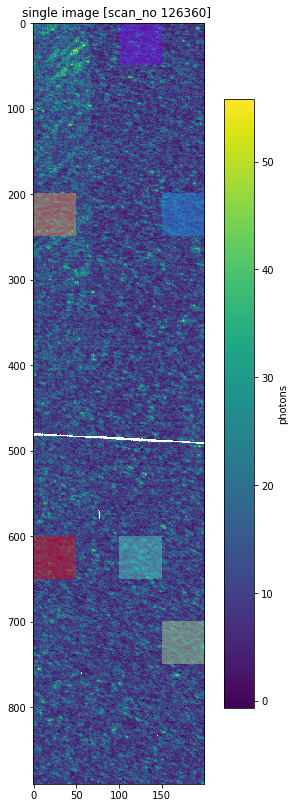

In [81]:
overlay_rois = True
#overlay_rois = False #TODO, add to widget and also fix intensity if overlay is left

fig, ax = plt.subplots(figsize=(7,14))
ax.set(title='single image [scan_no %s] ' %(h['start']['scan_id']))
im=ax.imshow(sub_images[1],#vmin=np.min(sub_images[1]), vmax=4,#np.max(sub_images[1]), 
             cmap='viridis', interpolation='none')
cbar = fig.colorbar(im, ax=ax,shrink=.8)
cbar.ax.set_ylabel('photons')

if len(rois) > 1 and overlay_rois is True:
    tmp = np.array(rois, dtype='float')
    tmp[rois==0] = np.nan
    ax.imshow(tmp, cmap='rainbow', interpolation='nearest', alpha=.4,)
    
maxphoton=np.nanmax(np.nanmax(sub_images[1,:,:],axis=1),axis=0)/ADUpPH
SUMphoton=np.nansum(np.nansum(sub_images[1,:,:],axis=1),axis=0)/ADUpPH   
print('APPROXIMATE ADU per photon:\t\t\t{:2.1f}'.format(ADUpPH))
print('Max number photon in 1 image ({}s):\t{:2.1f}'.format(exposuretime,maxphoton))
print('Number photons in 1 image ({}s):\t{:2.1f}\n\n'.format(exposuretime,SUMphoton))

In [15]:
browse_images(sub_images)

interactive(children=(IntSlider(value=0, description='i', max=199), Output()), _dom_classes=('widget-interact'…

### Select ROIS in Primary Area
* select `roi_mode` by using comment directly below
* if using `'rings'`, then select the type of `ring_names` for the ring rois
    * increase name monotonically up to the total number of all ring segments
    * number by azimuthal position for different radii for easy comparison
* if using `'rings'`, then define 
    * ` cen_v, cen_h, seg` 
    * the radii of each ring in each roi `loc`
* set up roi parameters in the respective dictionary
* pixel with `NaN` will cause roi in that frame to be eliminated from corr package

Scroll up to see ROI placement on image.

If using `segmented_rings()`, segments and center must be the same for all rings.



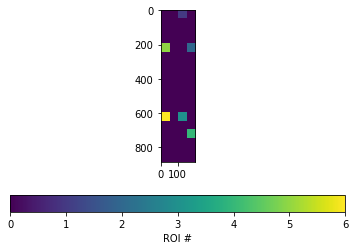

In [16]:
roi_area ='area1'
roi_mode = 'boxes'
#roi_mode = 'rings'

ring_names = 'match_radial_section'  #pie pieces with differing radius but same azimuth have same number
ring_names = 'match_mask_number'     #monotonic increase of roi# to match roi masked array plot


#rois=[]
vsize = sub_images.shape[1]
hsize = sub_images.shape[2]
# NAN in an ROI will cause that image to be skipped from the analysis




## RECTANGLES  -- USER DEFINED
#                         start v pix, start h pix, num v, num h
if roi_mode == 'boxes':
    roi_dict = {'roi1' : {'loc': (  0,     100,     50, 50), 'name' : 'one'},
                'roi2' : {'loc': (200,     150,     50, 50), 'name' : 'two'},
                'roi3' : {'loc': (600,     100,     50, 50), 'name' : 'three'},
                'roi4' : {'loc': (700,     150,     50, 50), 'name' : 'four'},
                'roi5' : {'loc': (200,       0,     50, 50), 'name' : 'overlap 2'},
                'roi6' : {'loc': (600,       0,     50, 50), 'name' : 'overlap 3'},
               }
    rois = roi.rectangles([roi_dict[x]['loc'] for x in roi_dict.keys()], shape=(vsize,hsize))
    roi_names = [roi_dict[x]['name'] for x in roi_dict.keys()]
    color_div = np.int(len(roi_dict)*2-1)


## RINGS (whole or segmented -  must be concentric) - USER DEFINED cen_v, cen_h, seg, and the radii of each ring
if roi_mode == 'rings':
    cen_v = 157
    cen_h = 147
    seg = 4 # integer or list for all - list not developed here #TODO make segment list work #TODO segment wrapping
    
    ##                                    ri, ro ;   pie pieces  ;         Cv, Ch
    #roi_dict = {'roi1' : {'loc': {'rad':( 46, 76), 'seg' : seg, 'cen' : (cen_v, cen_h)}, 'name' : 'ringA'},
    #            'roi2' : {'loc': {'rad':( 76,106), 'seg' : seg, 'cen' : (cen_v, cen_h)}, 'name' : 'ringB'},
    roi_dict = {'roi1' : {'loc': {'rad':( 46, 66), 'seg' : seg, 'cen' : (cen_v, cen_h)}, 'name' : 'ringA'},
                'roi2' : {'loc': {'rad':( 66,86), 'seg' : seg, 'cen' : (cen_v, cen_h)}, 'name' : 'ringB'},
                'roi3' : {'loc': {'rad':( 86,106), 'seg' : seg, 'cen' : (cen_v, cen_h)}, 'name' : 'ringC'},
               }
    rois = roi.segmented_rings([roi_dict[x]['loc']['rad'] for x in roi_dict.keys() ],   seg ,   (cen_v, cen_h), shape=(vsize,hsize)) 
    if ring_names == 'match_radial_section':
        roi_names = [[f'{roi_dict[x]["name"]}_{1+r}' for r in range(i*roi_dict[x]['loc']['seg'],roi_dict[x]['loc']['seg']*(i+1))]  for i,x in enumerate(roi_dict.keys())] #monotonic increase of roi# to match roi masked array plot
    if ring_names == 'match_mask_number':
        roi_names = [[f'{roi_dict[x]["name"]}_{1+r}' for r in range(roi_dict[x]['loc']['seg'])]  for i,x in enumerate(roi_dict.keys())]
    roi_names = list(itertools.chain(*roi_names))
    color_div = np.int(len(roi_dict)*seg*2-1)


rois = strip_pix_always_nan(sub_images,rois) 
area_dict[roi_area].update({'roi_mask':rois})

## plot ROIS for multi-tau in widget above
tmp = np.array(rois, dtype='float')
tmp[rois==0] = np.nan
ax.imshow(tmp, cmap='rainbow', interpolation='nearest', alpha=.4,)
print('Scroll up to see ROI placement on image.')
print('\nIf using `segmented_rings()`, segments and center must be the same for all rings.\n')

plt.figure()
im = plt.imshow(rois)#[150:170,195:230])
cbar = plt.colorbar(im,orientation = 'horizontal')
cbar.set_label('ROI #')

### Compute some basic information about the image stack
* hack for COM because of nans or use photoutils
* manually calculating for "peak" or "xpcs" area(s) for now. 
* plotting integrated and max intensity for all "areas" - can change
* plotting time normalized by msc slave ("scalar slave")

In [17]:
print('\tFor now, lets just characterize the jitter of the envelope - instabilty of diffraction peak position') 
com_address = np.array([ndimage.measurements.center_of_mass(im) for im in sub_images])
if np.isnan(com_address[0][0]) == True:
    print('\tnan\'s in image --> photutils from astropy handles it okay')
    from photutils import centroid_com
    com_address = np.array([np.flip(centroid_com(im)) for im in sub_images]) #Flip so that first value is for vertical pixel position
    #print('\tHACKY-CALC required due to nans because photutils in not available')
    #a = sub_images#
    #com_hack = np.copy(a)
    #for i in range(com_hack.shape[0]):
    #    nanmask = np.isnan(a[i])
    #    change_it = np.argwhere(nanmask==True)
    #    for it in change_it:
    #        com_hack[i, it[0],it[1]] = 3
    #com_address2 = np.array([ndimage.measurements.center_of_mass(im) for im in com_hack])

print(f'\nAreas on CCD that can be used to cull data:')
for k in area_dict.keys():
      print(f'\tarea_dict[\"{k}\"][\"name\"] = {area_dict[k]["name"]}')

	For now, lets just characterize the jitter of the envelope - instabilty of diffraction peak position
	nan's in image --> photutils from astropy handles it okay



Areas on CCD that can be used to cull data:
	area_dict["area1"]["name"] = xpcs
	area_dict["area2"]["name"] = bkgnd


In [18]:
framenumber = sub_images.shape[0]
#temperature = sample_details['sampleT'] # per frame is roughly available from the archiver....ASK ANDI TO GET THIS PART FOR  YOU unless you have it in the monitor stream

for k in area_dict.keys():
    temp_imgs = area_dict[k]['data']
    frame_sum = np.nansum(np.nansum(temp_imgs,axis=1),axis=1)
    frame_max = np.max(np.nanmax(temp_imgs,axis=1),axis=1)
    if area_dict[k]['name'] == 'xpcs' or area_dict[k]['name'] == 'peak':
        cull_data = {'vert-com':com_address[:,0], 
             'horz-com':com_address[:,1], 
             'intsum'  :frame_sum, 
             'intmax'  :frame_max,
            } 
    else:
        cull_data = {'intsum'  :frame_sum, 
                     'intmax'  :frame_max,
            } 
    area_dict[k].update({'1D_data': cull_data})

Text(0.5, 0, 'frames')

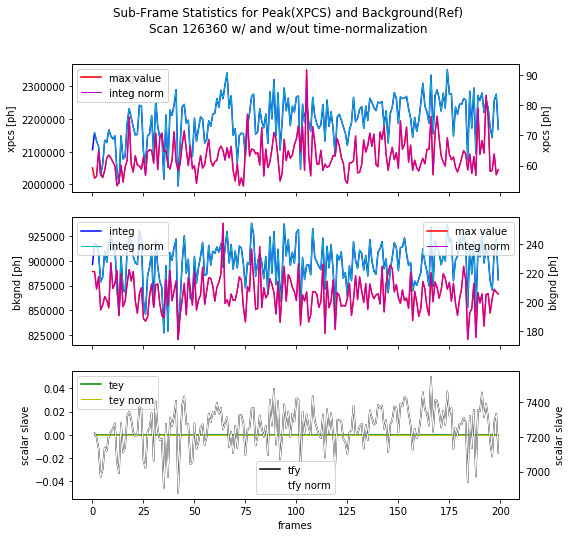

In [19]:
subplots = np.int(len(area_dict)+1)
fig, axes = plt.subplots(subplots,sharex=True, figsize=(8,8))
axes_R = np.zeros(subplots)
plt.suptitle(f'Sub-Frame Statistics for Peak(XPCS) and Background(Ref)\nScan {h.start["scan_id"]} w/ and w/out time-normalization')
for i, k in enumerate(area_dict.keys()):
    ax = axes[i]
    axR = axes_R[i]
    ax.plot(np.arange(area_dict[k]['1D_data']['intsum'].shape[0]),area_dict[k]['1D_data']['intsum'],'b',label='integ ')
    ax.plot(np.arange(area_dict[k]['1D_data']['intsum'].shape[0])[1::],area_dict[k]['1D_data']['intsum'][1::]/ mcs_time[0] *mcs_time[0].mean(),'c',label='integ norm', linewidth = 1)
    axR = ax.twinx()
    axR.plot(np.arange(area_dict[k]['1D_data']['intmax'].shape[0]),area_dict[k]['1D_data']['intmax'],'r',label='max value')
    axR.plot(np.arange(area_dict[k]['1D_data']['intmax'].shape[0])[1::],area_dict[k]['1D_data']['intmax'][1::]/ mcs_time[0] *mcs_time[0].mean(),'m',label='integ norm', linewidth = 1)

    ax.set_ylabel(f'{area_dict[k]["name"]} [ph]')
    axR.set_ylabel(f'{area_dict[k]["name"]} [ph]')
    ax.legend(loc=2)
    axR.legend()

ax = axes[np.int(subplots-1)]
axR = axes_R[np.int(subplots-1)]
ax.plot(np.arange(1,len(mcs_tey[0])+1), mcs_tey[0], 'g', label='tey')
ax.plot(np.arange(1,len(mcs_tey[0])+1), mcs_tey[0]/mcs_time[0] *mcs_time[0].mean(), 'y', label='tey norm', linewidth = 1)
axR = ax.twinx()
axR.plot(np.arange(1,len(mcs_tfy[0])+1), mcs_tfy[0], 'k', label='tfy')
axR.plot(np.arange(1,len(mcs_tfy[0])+1), mcs_tfy[0]/mcs_time[0] *mcs_time[0].mean(), 'w', label='tfy norm', linewidth = 1)
ax.set_ylabel('scalar slave')
axR.set_ylabel('scalar slave')
ax.legend(loc=2)
axR.legend()

ax.set_xlabel('frames')

####TODO understand why large spikes in bkg max pix

####TODO wait for matplotlib update on server (3.1 version)
# ax2 = ax1.twiny()               
# ax1Xs = ax1.get_xticks()

# ax2Xs = []
# for X in ax1Xs:
#     ax2Xs.append(np.ceil(X /lag_time))

# ax2.set_xlim(ax1Xs[0],ax1Xs[-1])
# ax2.set_xbound(ax1.get_xbound())
# ax2.set_xticklabels(ax2Xs)

#ax.set_xlabel('time [s]')

# def time2frame(x):   
#     x / lag_time
    
# def frame2time(x):
#     x * lag_time
# secax = ax.secondary_xaxis('top', functions=(time2frame, frame2time))
# secax.set_xlabel('angle [rad]')
# plt.show()



##### Other normalization plots. ################
# fig, axes = plt.subplots(2,sharex=False,figsize=(3,7))
# plt.suptitle(f'')
# axes[0].plot(np.arange(Img_bkg_sum_t.shape[0])[1::],mcs_time[0]-mcs_time[0].mean(),label='mcs_time - average (y=MHz, 50MHz =1s)')
# axes[1].plot(np.arange(Img_bkg_sum_t.shape[0])[1::],mcs_time[0]/50e6,label='(mcs_time / 50e6 (y=seconds)')
# #axes[2].plot(np.arange(Img_bkg_sum_t.shape[0])[1::],mcs_time[0]/mcs_time[0]*mcs_time[0].mean(),label='mcs_time')
# #axes[2].plot(np.arange(Img_bkg_sum_t.shape[0])[1::]*lag_time,mcs_tfy[0]/mcs_time[0]*mcs_time[0].mean(),label='mcs_tfy norm')

## intensity (avg or max) plots of ROIS and frame eliminations
* chose maximum or average to plot by setting `INTplots`
* Here we also do COM but for this scattering this probably isn't useful

In [20]:
INTplots = 'avg'
#INTplots = 'max'  #TODO add correct function to roi library of skbeam

intensities = {}
print('Compiling inspection data for ROIs:')
for i,n in enumerate(roi_names):
    print(f'\r\t{i}, {n}', end='')
    if INTplots == 'avg':
        intensities.update({n:roi.mean_intensity(sub_images, rois, index=i+1)})
    elif INTplots == 'max':
        #intensities.update({n:roi.roi_max_counts(np.reshape(sub_images,(1,sub_images.shape[0],sub_images.shape[1],sub_images.shape[2])), rois, index=i+1)}) ##TODO fiure out why this doens't work
        print('This does not work as expected')

print(f'\n\nCull data from FCCD areas:')
for k in area_dict.keys():
    print(f'{k} - {area_dict[k]["name"]}' )
    print(f'\t{[kd for kd in area_dict[k]["1D_data"].keys()]}')
    
print(f'\ncullit = {cullit}.  Set to True to mask bad frames.  Re-run notebook to revert.')

Compiling inspection data for ROIs:
	5, overlap 3

Cull data from FCCD areas:
area1 - xpcs
	['vert-com', 'horz-com', 'intsum', 'intmax']
area2 - bkgnd
	['intsum', 'intmax']

cullit = False.  Set to True to mask bad frames.  Re-run notebook to revert.


### set up culling if needed in next cell, then apply it or don't
* set `cullon` to a key to explore.  all possiblities will be saved if `cullon != None`
* standard deviation units can be adjusted
* set `cullit = True` to remove data from skbeam analysis
* make manual alteradtion to culling mask, first cell is preview only.

		 mean		stdev	skew		kurtosis
vert-com:	    435.79      1.17	-0.27		-0.77
	mode        433.12			
    4ths up         436.69
   4ths dwn         434.91
horz-com:	     95.56      0.24	-0.21		-0.38
	mode         94.99			
    4ths up          95.74
   4ths dwn          95.41
intsum:	2197878.25  68196.66	-0.54		 0.08
	mode    1994550.75			
    4ths up     2250670.00
   4ths dwn     2154785.60
intmax:	     63.24      5.71	 1.22		 2.99
	mode         53.20			
    4ths up          65.71
   4ths dwn          59.44


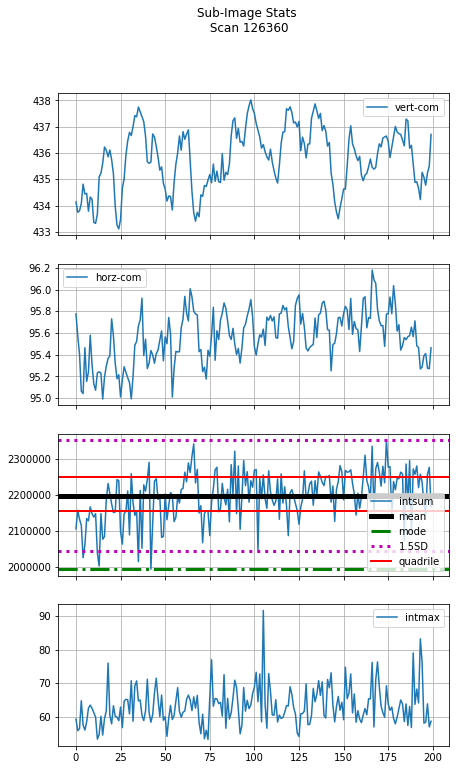

In [21]:
cullit = False
#cullit = True
cull_data_now = area_dict['area1']['1D_data']
orig_keys = ['vert-com', 'horz-com', 'intsum', 'intmax']
cull_stats = {}
cullon = None
cullon = 'vert-com'
#cullon = 'horz-com'
cullon = 'intsum'
#cullon = 'intmax'
StdDevUnits = 1.5
mask = np.ones(sub_images.shape[0])

i=cull_data_now   #TODO turn this into a function if keeping notebook
key_removal = []
for k in i.keys():
    if k not in orig_keys:
        key_removal.append(k)
for k in key_removal:
    i.pop(k)

if cullon is None:
    print('No proposed cull parameters - not saving any derived statistics about 1D data')
else:
    #TODO deleted stats? 
    #TODO fix re-run of cell
    print('\t\t mean\t\tstdev\tskew\t\tkurtosis')
    for k in cull_data_now.keys():
        describe = stats.stats.describe(cull_data_now[k],nan_policy='omit')#TODO think about using stats.stats.mstats.zscore https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.zscore.html#scipy.stats.mstats.zscore 
        mode  = stats.mode(cull_data_now[k],nan_policy='omit').mode[0]#TODO this not working correctly if there is not atleast 2 of the same values, then it picks last
        print(f'{k}:\t{describe.mean:>10.2f}{np.sqrt(describe.variance):>10.2f}\t{describe.skewness:>5.2f}\t\t{describe.kurtosis:>5.2f}\n\tmode{mode:14.2f}\t\t\t') 
        fourths = stats.mstats.idealfourths(cull_data_now[k])
        print(f'    4ths up {fourths[1]:14.2f}\n   4ths dwn {fourths[0]:14.2f}')
        #cull_stats.update({'mean':describe.mean, 'stdev':np.sqrt(describe.variance)*StdDevUnits , 'mode' : mode, 'quad':fourths})
        cull_stats.update({f'{k}_stats' : {'mean':describe.mean, 'stdev':np.sqrt(describe.variance)*StdDevUnits , 'mode' : mode, 'quad':fourths}})

    vfigsize = np.int( len(cull_data_now.keys())*3 )

    fig, axs = plt.subplots(len(cull_data_now.keys()),figsize=(7,vfigsize), sharex=True)
    plt.suptitle(f'Sub-Image Stats\n Scan {h.start["scan_id"]}')
    for i,k in enumerate(cull_data_now.keys()):
        ax = axs[i]
        #ax.set_ylabel('Avg Int [ph]')
        ax.plot(np.arange(cull_data_now[k].shape[0]),cull_data_now[k], label = k)
        ax.grid(True)
        if k == cullon:    
            ax.axhline(cull_stats[f'{k}_stats']['mean'], linestyle='-', color='k', linewidth=5, label='mean')
            ax.axhline(cull_stats[f'{k}_stats']['mode'],linestyle='-.', color='g', linewidth=3, label='mode')
            ax.axhline(cull_stats[f'{k}_stats']['mean']+cull_stats[f'{k}_stats']['stdev']*StdDevUnits, linestyle=':', color='m', linewidth=3, label=f'{StdDevUnits}SD')
            ax.axhline(cull_stats[f'{k}_stats']['mean']-cull_stats[f'{k}_stats']['stdev']*StdDevUnits, linestyle=':', color='m', linewidth=3)        
            ax.axhline(cull_stats[f'{k}_stats']['quad'][0], linestyle='-', color='r', linewidth=2, label=f'quadrile')
            ax.axhline(cull_stats[f'{k}_stats']['quad'][1], linestyle='-', color='r', linewidth=2)
        ax.legend()
        
    cull_data_now.update(cull_stats)
   
    if cullit is True:
        cullpars = cull_stats[f'{cullon}_stats']
        #TODO make this less handsy, generalize
        mask = np.logical_and(cull_data_now[cullon] >= cullpars['mean'] - cullpars['stdev']*StdDevUnits, cull_data_now[cullon] <= cullpars['mean'] + cullpars['stdev']*StdDevUnits)  
        print('culling')
        for i,k in enumerate(orig_keys):
            ax = axs[i]
            temp = np.copy(cull_data_now[k])
            temp[~np.invert(mask)]=np.nan
            ax.plot(np.arange(temp.shape[0]),temp, 'ro' , markerfacecolor='w',label = k)
        
        #temp
        #mask[~mask] = np.nan      

In [22]:
if cullit is True and cullitdone is False:
    print('WARNING:  the next cell will elminate frames from analysis.')

In [23]:
#TODO fix this to use less memory.  for some reason, broadcasting does not work as I expect
mask_imgs=np.ones(sub_images.shape)
if cullit is True and cullitdone is False:
    print('culling with mask')       
    mask_imgs[~mask]=np.nan
    if np.isnan(mask_imgs) is False:
        'WARNING: all images are being considered. Re-run cell that manages culling'
    area_dict[roi_area].update({'frame_mask':mask})
if cullit is True and cullitdone is True:
    print('mask is set to cull')
else:
    print('All frames are being considered')
    mask = np.ones(sub_images.shape[0])
    area_dict[roi_area].update({'frame_mask':mask})

All frames are being considered


In [24]:
%matplotlib inline

### TODO - need to work out with Tatiana if she wants individual ROI stats masked or always present with option to mask
* right now, ROI stats, if they are saved, they are not masked

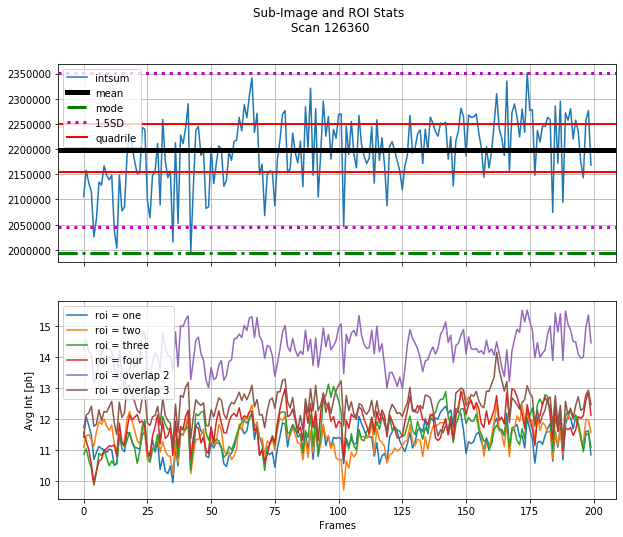

In [25]:
norm_data = 1
vfigsize = np.int( (len(roi_dict)+len(cull_data.keys()))*1 )

fig, axes = plt.subplots(2,figsize=(10,vfigsize), sharex=True)
plt.suptitle(f'Sub-Image and ROI Stats\n Scan {h.start["scan_id"]}')
if cullon is None:
    k = 'peak-intsum'
else:
    k = cullon
ax = axes[0]
ax.plot(np.arange(cull_data_now[k].shape[0]),cull_data_now[k], label = k)
if cullit is True and cullitdone is True:
    temp = np.copy(cull_data_now[k])
    temp[~np.invert(mask)]=np.nan
    ax.plot(np.arange(temp.shape[0]),temp, 'ro' , markerfacecolor='w',label = 'culled')
ax.grid(True)
if k == cullon:    
    ax.axhline(cull_stats[f'{k}_stats']['mean'], linestyle='-', color='k', linewidth=5, label='mean')
    ax.axhline(cull_stats[f'{k}_stats']['mode'],linestyle='-.', color='g', linewidth=3, label='mode')
    ax.axhline(cull_stats[f'{k}_stats']['mean']+cull_stats[f'{k}_stats']['stdev']*StdDevUnits, linestyle=':', color='m', linewidth=3, label=f'{StdDevUnits}SD')
    ax.axhline(cull_stats[f'{k}_stats']['mean']-cull_stats[f'{k}_stats']['stdev']*StdDevUnits, linestyle=':', color='m', linewidth=3)        
    ax.axhline(cull_stats[f'{k}_stats']['quad'][0], linestyle='-', color='r', linewidth=2, label=f'quadrile')
    ax.axhline(cull_stats[f'{k}_stats']['quad'][1], linestyle='-', color='r', linewidth=2)
ax.legend()
   
ax=axes[1]
for i,d in enumerate(intensities):
    ax.plot(np.arange(intensities[d][0].shape[0]),intensities[d][0]*norm_data, label = f'roi = {d}')
    if cullit is True and cullitdone is True:
        temp = np.copy(intensities[d][0])
        temp[~np.invert(mask)]=np.nan
        ax.plot(np.arange(temp.shape[0]),temp*norm_data, 'ro' , markerfacecolor='w')
    ax.set_ylabel('Avg Int [ph]')
    ax.legend()
ax.set_xlabel('Frames')
ax.grid(True)
    
#filename = 'S' + np.str(h.start['scan_id']) + '_data_quality.png'
#plt.savefig(filename)

### Why call it a **speckle-ogram** and not use the function name (kymograph)?
In actuality, the **"ograph"** is the device that measures/produces and the graphical representation is the **"ogram"**.  Waterfall also appears to be a valid term to describe, but XPD/PDF uses this term in a different way.
https://dsp.stackexchange.com/questions/2426/terminology-spectrum-spectrogram-spectrograph-sonogram-etc

Compiling inspection data for ROIs:
	5, overlap 3

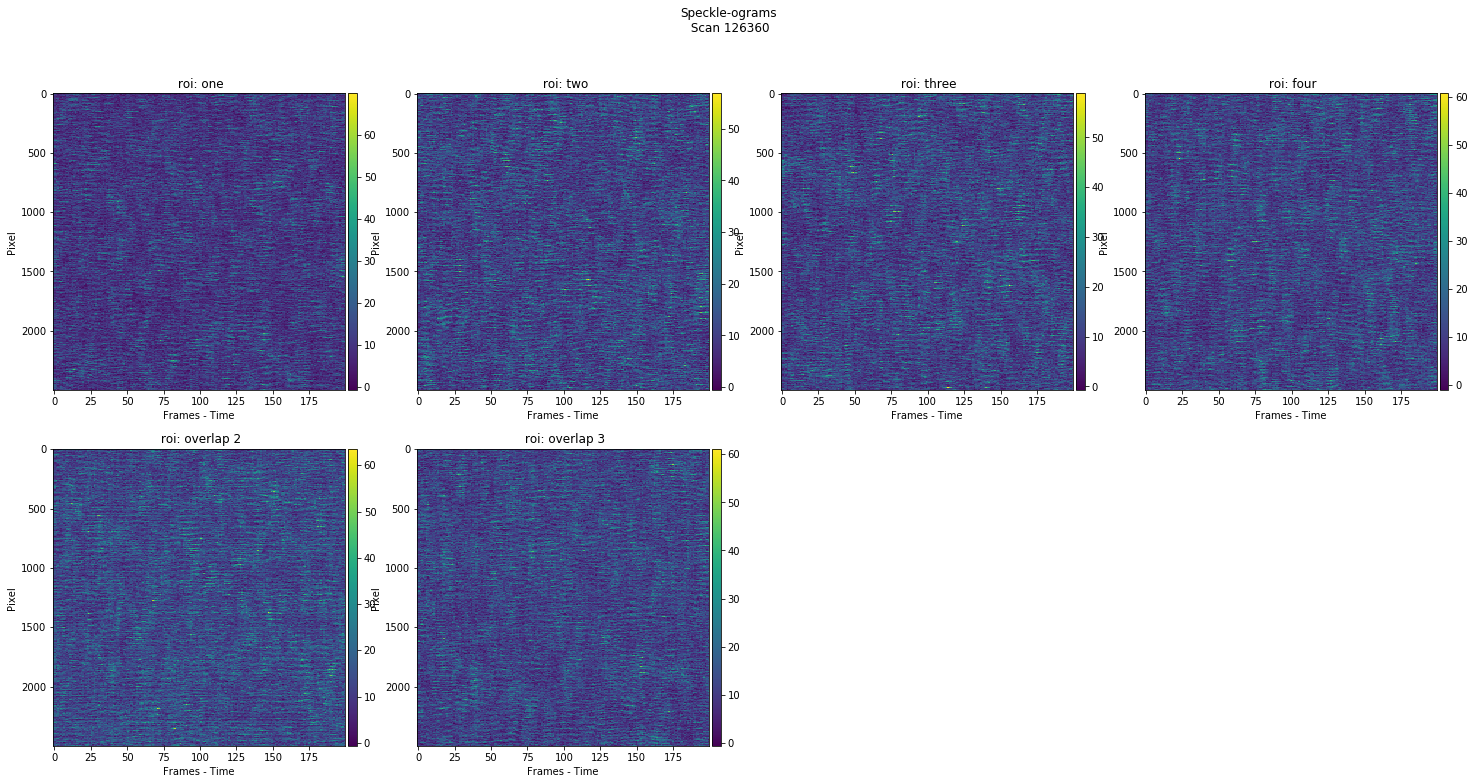

In [26]:
#INTplots = 'avg'
#INTplots = 'max'  #TODO add correct function to roi library of skbeam

waterfalls =[]
#intensities = {}
print('Compiling inspection data for ROIs:')
for i,n in enumerate(roi_names):
    print(f'\r\t{i}, {n}', end='')
    temp=roi.kymograph(sub_images*mask_imgs,rois,num=i+1)  #this is because this function does not return iterable kymographs
    waterfalls.append(temp)
    #if INTplots == 'avg':
    #    intensities.update({n:roi.mean_intensity(sub_images*mask, rois, index=i+1)})
    #elif INTplots == 'max':
    #    #intensities.update({n:roi.roi_max_counts(np.reshape(sub_images*mask,(1,sub_images.shape[0],sub_images.shape[1],sub_images.shape[2])), rois, index=i+1)}) ##TODO fiure out why this doens't work
    #    print('This does not work as expected')
waterfalls = np.array(waterfalls)

row_figs = 4
col_figs = np.int(np.ceil(len(roi_names)/4))

fig=plt.figure(figsize=(25,np.int(col_figs*6)))
for i,n in enumerate(roi_names):
    #cbar_lim = colorbar_method[set_cbar_method]
    #if set_cbar_method == 'percentile':
    #    cmin = np.percentile(img, cbar_lim[0] )
    #   cmax = np.percentile(img, cbar_lim[1] )
    #elif set_cbar_method == 'absolute' or set_cbar_method == 'automatic':
    #    cmin = cbar_lim[0]
    #    cmax = cbar_lim[1]
    fig.add_subplot(col_figs, row_figs, np.int(i+1))
    im = plt.imshow(waterfalls[i].T, interpolation='Nearest',cmap='viridis', aspect='auto')#vmin = cmin, vmax = cmax)
    ax = fig.gca()
    divider = make_axes_locatable(ax)
    fig.colorbar(im, ax=ax, cax =   divider.append_axes("right", "3%", pad="1%"))
    ax.set(ylabel='Pixel', xlabel='Frames - Time', title=f' roi: {n}' )
plt.suptitle(f'Speckle-ograms\n Scan {h.start["scan_id"]}')
plt.show()

## One-time g2
* for equilibrium dynamics only

In [27]:
f_beg = 0
f_end = sub_images.shape[0]

Asub_images=sub_images[f_beg:f_end,:,:]*mask_imgs[f_beg:f_end]  #THEREFORE MASK APPLIED TO ALL FOLLOWING CALCULATIONS using Asub_images

num_levels = 12#16# 1
num_bufs =  12#16#Asub_images.shape[0] #4
# 1 and number of images respectively, for brute force got levels and buffers
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, rois, Asub_images)
#print(g2.shape)
#print(lag_steps.shape)

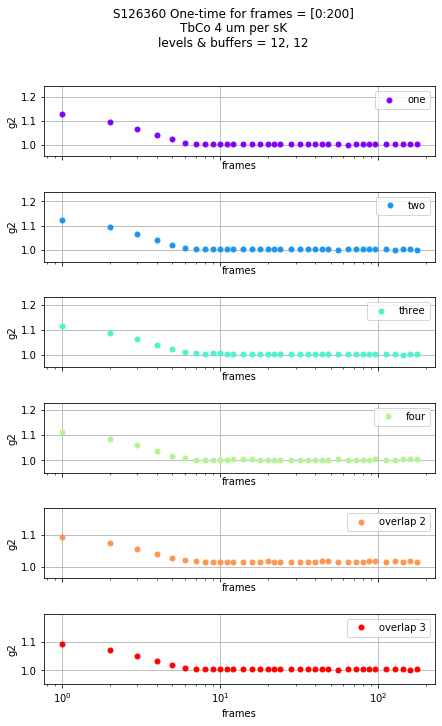

In [28]:
#lag_steps = lag_steps[:g2.shape[0]]
lag_time = lag_steps*frametime

fig, axes = plt.subplots(g2.shape[1], sharex=True, figsize=(7,color_div))
purpose = descript#h['start'].get('purpose',tbl.stemp_temp_B_T.mean())
plt.suptitle(f'S{scan_no} One-time for frames = [{f_beg}:{f_end}]\n{purpose}K\nlevels & buffers = {num_levels}, {num_bufs}')
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for ax, roi_color, g, r in zip(axes, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div)), g2.T, roi_names):
#for ax, roi_color, g, in zip(axes, cm.get_cmap('rainbow')(np.linspace(0, 3, 9)), g2.T):
    floor = np.min(g)-.05
    ceiling = np.max(g)
    ax.semilogx(lag_steps, g, 'o', markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = r)
    #ax.semilogx(lag_time, g, 'o',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = r)
    ax.set_ylabel('g2')
    ax.set_xlabel('frames')
    #ax.set_xlabel('time [s]')
    ax.set_ylim(floor, ceiling)
    ax.grid(True)
    ax.legend()
    

In [29]:
# filename = 'S' + np.str(h.start['scan_id']) + f'_one-time_{num_levels}lev_{num_bufs}buf.png'
# plt.savefig(filename)


[Text(0.5, 0, 'frames')]

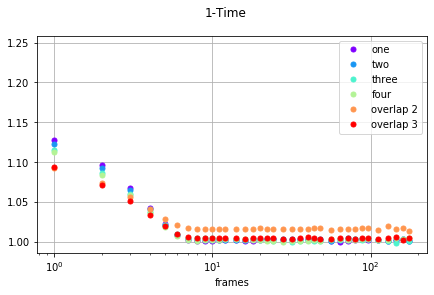

In [30]:
fig = plt.figure(figsize=(7,4))
plt.suptitle('1-Time')
fig.add_subplot(111)
ax = fig.gca()
for  g, r, roi_color in zip(g2.T, roi_names, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div))):
    ax.semilogx(lag_steps, g,                      'o',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}')
    #ax.semilogx(lag_time, g,                      'o',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}')
ax.legend(loc=1)
ax.grid(True)
#ax.set(xlabel='time[s]')
ax.set(xlabel='frames')

## Fitting one-time g2 - stupid quess

OVERFIT WITH GUESSES- have to use constraints with this method even if closer guess
fix extrapolation for small time 


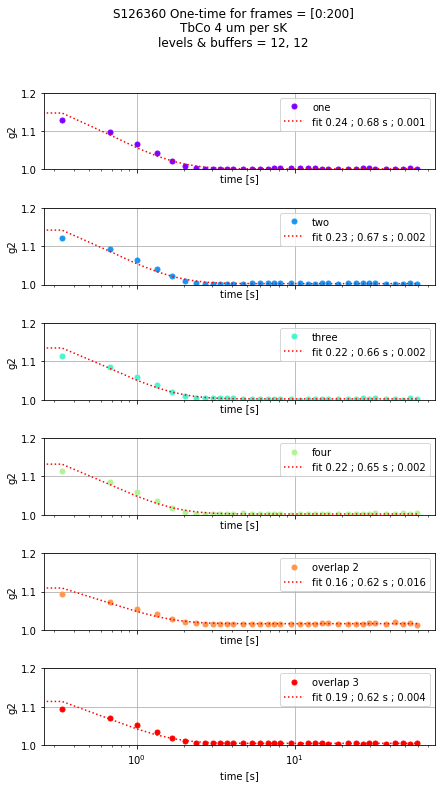

In [31]:
best_vals_guess = [ np.array([.2, 2,0]) for i in range(color_div) ]  # rough, raw guesses for contrast, tau, and background
best_guess =[]
fig, axes = plt.subplots(g2.shape[1], sharex=True, figsize=(7,12))
purpose = descript
plt.suptitle(f'S{scan_no} One-time for frames = [{f_beg}:{f_end}]\n{purpose:}K\nlevels & buffers = {num_levels}, {num_bufs}')
fig.subplots_adjust(hspace=0.5, wspace=0.5)

#for ax, roi_color, g, best_guess, r in zip(axes, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div)), g2.T, g2_lin, roi_names):
for ax, roi_color, g, best_guess, r in zip(axes, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div)), g2.T, best_vals_guess, roi_names):
    floor = np.min(g)-.05
    ceiling = np.max(g)
    #ax.semilogx(lag_steps, g, 'o', markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = r)
    ax.semilogx(lag_time, g, 'o',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = r)
    ax.set_ylabel('g2')
    #ax.set_xlabel('frames')
    ax.set_xlabel('time [s]')
    #ax.set_ylim(floor, ceiling)
    #print(best_guess) ######################### print best guesss
    best_vals, covar = curve_fit(single_exp, lag_time, g, p0=best_guess)
    ax.semilogx(lag_time, single_exp(lag_time, best_vals[0], best_vals[1], best_vals[2]), ':r', label = f'fit {best_vals[0]:.2f} ; {best_vals[1]:.2f} s ; {best_vals[2]:.3f}')
    ax.grid(True)
    ax.legend()
    ax.set_ylim(1,1.2)
    

print('OVERFIT WITH GUESSES- have to use constraints with this method even if closer guess') #TODO look into this
print('fix extrapolation for small time ') #TODO fix fit extrapolation

In [32]:
%matplotlib inline

In [33]:
# filename = 'S' + np.str(h.start['scan_id'])  + f'_one-time_{num_levels}lev_{num_bufs}buf_fit.png'
# plt.savefig(filename)

## Two Time (2 methods)

* `pyCHX.chx_correlation.two_time_corr`
    * looks like broken here, so another mismatch with skbeam.correlation.py
    * should we fix it?  This function has a test in skbeam
    * does fixing it break the other function (`pyCHX.Two_Time_Correlation_Functions.auto_two_Array`)
* `pyCHX.Two_Time_Correlation_Functions.auto_two_Array` 
    * input is just images and roi_masked_array.  `skbeam.correlation.two_time_corr` requires shape and can do multi-tau
        * Personally, AB okay with not having this functionality
        * Maybe other people will miss it? 
    * g2 output is Transposed compared to `skbeam.correlation.two_time_corr` (now c order array instead of f order array)
    * Uses `tqdm`.  Does this scale with paralleization using joblib or something?

In [34]:
num_bufs_tt = Asub_images.shape[0]
num_levels_tt = 1
##### pyCHX original function from chx_correlations.py, which is supposed to be the "same" as skbeam.core.correlations.py
g2_tt, lag_steps_tt, _state = corr.two_time_corr(rois, Asub_images, Asub_images.shape[0], num_bufs_tt, num_levels_tt)
#IndexError on --> 632         tind2 = (current_img_time - lag_steps[t_index] - 1)


print(g2_tt.shape)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
num_bufs_tt = Asub_images.shape[0]
num_levels_tt = 1

#### pyCHX test#2 --- from Two_Time_Correlation_Functions
g2_tt = corr2t.auto_two_Array(Asub_images,rois)

print(g2_tt.shape)

100%|██████████| 6/6 [00:00<00:00, 120.56it/s]

Total time: 0.00 min
(200, 200, 6)


In [36]:
#g2_tt_pyCHX = g2_tt
#g2_tt = g2_tt.T
#print(g2_tt.shape)

## For all interable 2t from `pyCHX.Two_Time_Correlation_Functions`
* add `.T` when iterating over `zip()`

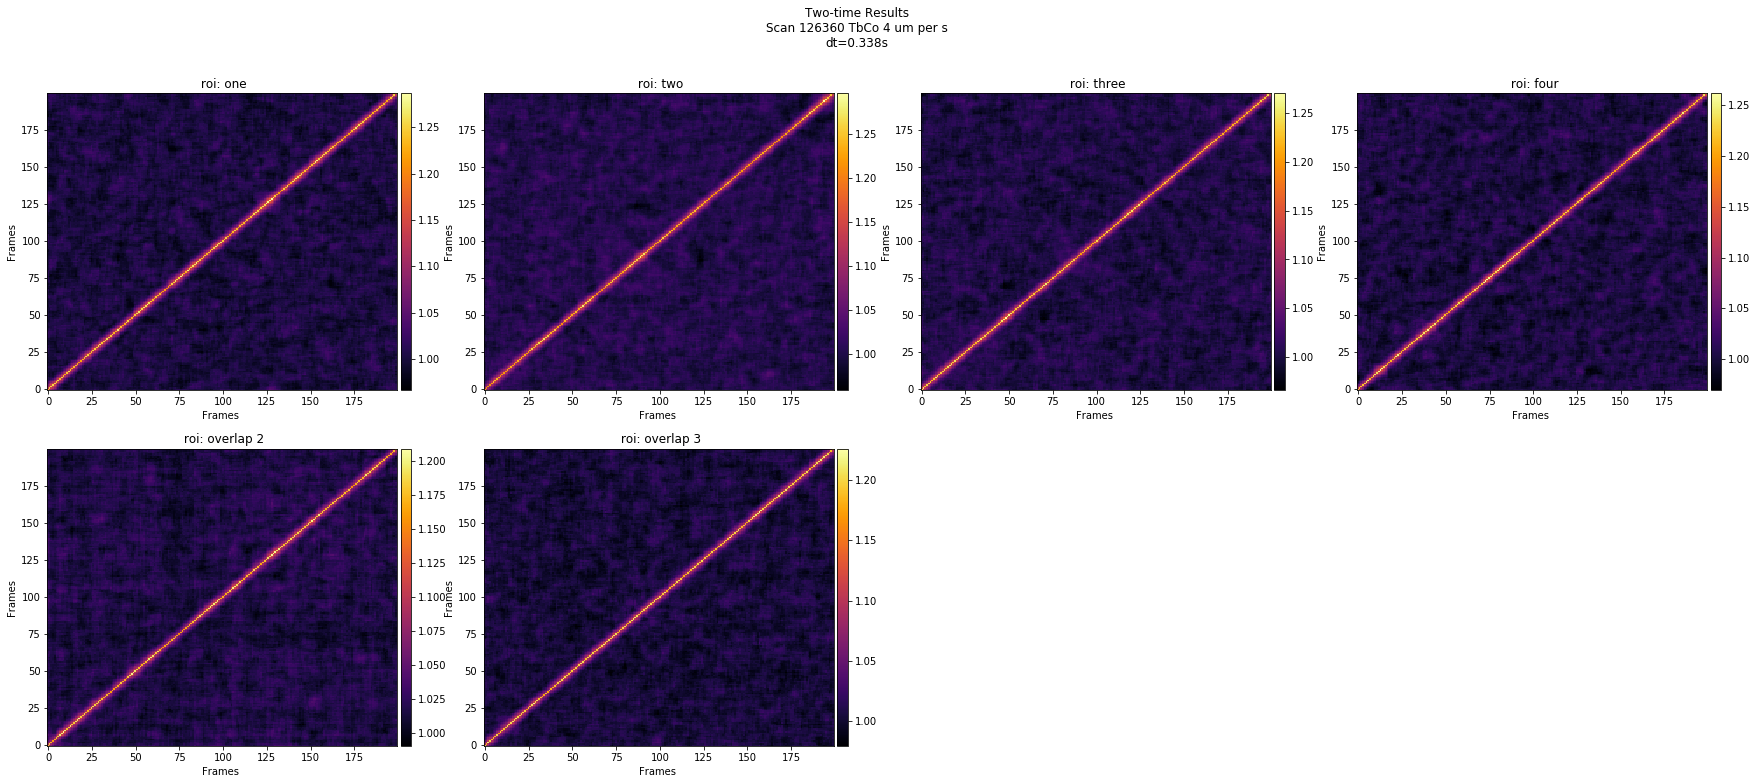

In [37]:
row_figs = 4
col_figs = np.int(np.ceil(len(roi_names)/4))

%matplotlib inline
fig=plt.figure(figsize=(30,np.int(col_figs*6)))
for i, g, r, im in zip(range(1, len(roi_names)+1) , g2_tt.T, roi_names,np.arange(len(roi_names))):
    #cbar_lim = colorbar_method[set_cbar_method]
    #if set_cbar_method == 'percentile':
    #    cmin = np.percentile(img, cbar_lim[0] )
    #   cmax = np.percentile(img, cbar_lim[1] )
    #elif set_cbar_method == 'absolute' or set_cbar_method == 'automatic':
    #    cmin = cbar_lim[0]
    #    cmax = cbar_lim[1]
    fig.add_subplot(col_figs, row_figs, i)
    im = plt.imshow(g, interpolation='Nearest',cmap='inferno', aspect='auto',origin={0,0})#, vmin =1)#vmin = cmin, vmax = cmax)
    ax = fig.gca()
    divider = make_axes_locatable(ax)
    fig.colorbar(im, ax=ax, cax =   divider.append_axes("right", "3%", pad="1%"))
    ax.set(ylabel='Frames', xlabel='Frames ', title=f' roi: {r}' )
plt.suptitle(f'Two-Time\n Scan {h.start["scan_id"]}')
purpose = descript #h['start'].get('purpose',tbl.stemp_temp_B_T.mean())
plt.suptitle(f'Two-time Results\nScan {h.start["scan_id"]} {purpose}\ndt={sample_details["dt"]:.3f}s')
plt.show()


In [38]:
#filename = 'S' + np.str(h.start['scan_id']) + '_two-time.png'
#plt.savefig(filename)

### Explore two-time interactively
* set `i` to the nth roi whose colorbar scale you want

In [39]:
#%matplotlib widget
#print('getting widget back')

In [40]:
# %matplotlib widget
# print('getting widget back to explore Two-Time')
# print('Set i = to the nth roi color bar you want')

['one', 'two', 'three', 'four', 'overlap 2', 'overlap 3']


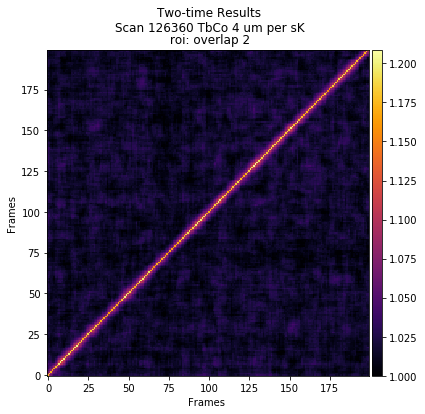

In [41]:
i = 4
print(roi_names)

fig=plt.figure(figsize=(6,6))
fig.add_subplot(1,1, 1)
im = plt.imshow(g2_tt.T[i], interpolation='Nearest',cmap='inferno', aspect='auto',origin={0,0}, vmin =1)#vmin = cmin, vmax = cmax)
ax = fig.gca()
divider = make_axes_locatable(ax)
fig.colorbar(im, ax=ax, cax =   divider.append_axes("right", "3%", pad="1%")) #TODO fix browser_images to allow for colorbar update or fix
ax.set(ylabel='Frames', xlabel='Frames ', title=f' roi: {roi_names[i]}' )
plt.suptitle(f'Two-Time\n Scan {h.start["scan_id"]}')
purpose = descript #h['start'].get('purpose',tbl.stemp_temp_B_T.mean())
plt.suptitle(f'Two-time Results\nScan {h.start["scan_id"]} {purpose}K')
plt.show()

In [ ]:
browse_images(g2_tt, 'nth roi')

## 1t to 2t (3 methods)
* `chx_correlation.one_time_from_two_time` 
    * is not correct even when we correct for the unexpected shape.  
    * this function requires f order array (rois, number of frames, number of frames)
    * the issue is dealt with in PR for skbeam
        * https://github.com/scikit-beam/scikit-beam/pull/566
        * https://github.com/scikit-beam/scikit-beam/blob/5a4332af41ea43f2943c0b8e01d5babf2195cb80/skbeam/core/correlation.py#L918
* `Two_Time_Correlation_Functions.get_one_time_from_two_time_old`
    * Works, have to correct plotting but otherwise okay
    * Output that looks nearly correct if the two-time array is transposed (rois, number of frames, number of frames)
        * link of gist
    * DId not test with `nopr` and `norms` - CSX does not have in pipeline so this is lower priority
* `Two_Time_Correlation_Functions.get_one_time_from_two_time`
    * More effecient, but otherwise the same as `..._old`

In [42]:
g2_tt.T.shape

(6, 200, 200)

In [43]:
onetime = corr.one_time_from_two_time(g2_tt.T) 
print(onetime.shape)

(6, 200)


[Text(0.5, 0, 'time[s]')]

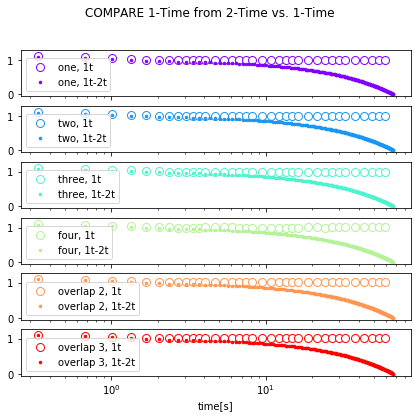

In [44]:
fig, axes = plt.subplots(g2_tt.T.shape[0], figsize=(7,1*len(roi_names)))
plt.suptitle('COMPARE 1-Time from 2-Time vs. 1-Time')
for ax, g, g1t, ot, r, roi_color in zip(axes, g2_tt.T,g2.T, onetime, roi_names, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div))):
    ax.semilogx(lag_time, g1t,                      'o',markerfacecolor='w', markersize=8, markeredgecolor=roi_color, label = f'{r}, 1t')
    ax.semilogx(np.arange(g.shape[1])*frametime,ot, '.',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}, 1t-2t')
    ax.legend()
    ax.grid
ax.set(xlabel='time[s]')

In [45]:
g2_tt.shape

(200, 200, 6)

In [46]:
onetime = corr2t.get_one_time_from_two_time_old(g2_tt)
print(onetime.shape)

(200, 6)


[Text(0.5, 0, 'time[s]')]

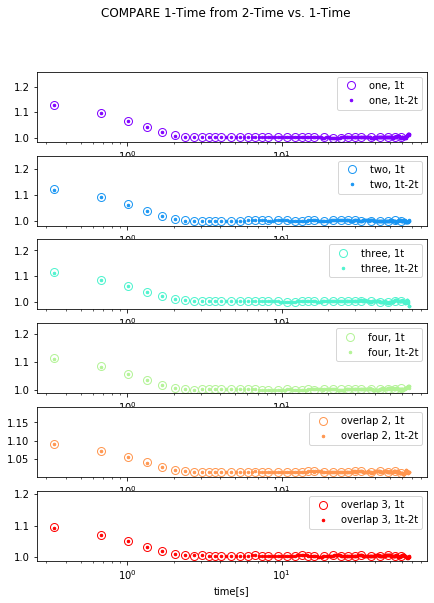

In [47]:
fig, axes = plt.subplots(g2_tt.T.shape[0], figsize=(7,1.5*len(roi_names)))
plt.suptitle('COMPARE 1-Time from 2-Time vs. 1-Time')
for ax, g, g1t, ot, r, roi_color in zip(axes, g2_tt.T, g2.T, onetime.T, roi_names, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div))):
    ax.semilogx(lag_time, g1t,                      'o',markerfacecolor='w', markersize=8, markeredgecolor=roi_color, label = f'{r}, 1t')
    ax.semilogx(np.arange(g.shape[1])*frametime,ot, '.',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}, 1t-2t')
    ax.legend()
    ax.grid
ax.set(xlabel='time[s]')

In [48]:
onetime = corr2t.get_one_time_from_two_time(g2_tt)
print(onetime.shape)

(200, 6)


[Text(0.5, 0, 'time[s]')]

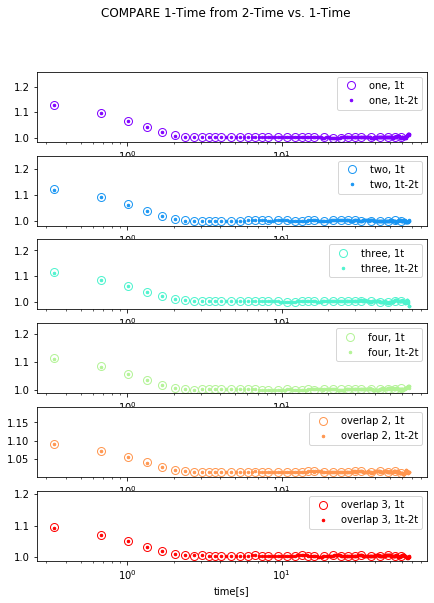

In [49]:
fig, axes = plt.subplots(g2_tt.T.shape[0], figsize=(7,1.5*len(roi_names)))
plt.suptitle('COMPARE 1-Time from 2-Time vs. 1-Time')
for ax, g, g1t, ot, r, roi_color in zip(axes, g2_tt.T, g2.T, onetime.T, roi_names, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div))):
    ax.semilogx(lag_time, g1t,                      'o',markerfacecolor='w', markersize=8, markeredgecolor=roi_color, label = f'{r}, 1t')
    ax.semilogx(np.arange(g.shape[1])*frametime,ot, '.',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}, 1t-2t')
    ax.legend()
    ax.grid
ax.set(xlabel='time[s]')

[Text(0.5, 0, 'time[s]')]

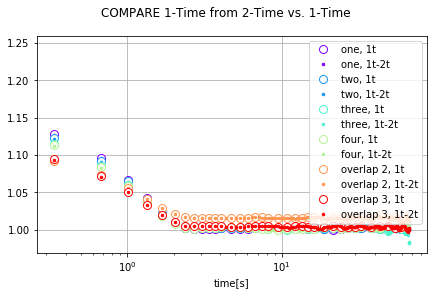

In [50]:
fig = plt.figure(figsize=(7,4))
plt.suptitle('COMPARE 1-Time from 2-Time vs. 1-Time')
fig.add_subplot(111)
ax = fig.gca()
for  g, g1t, ot, r, roi_color in zip( g2_tt.T, g2.T, onetime.T, roi_names, cm.get_cmap('rainbow')(np.linspace(0, 2, color_div))):
    ax.semilogx(lag_time, g1t,                      'o',markerfacecolor='w', markersize=8, markeredgecolor=roi_color, label = f'{r}, 1t')
    ax.semilogx(np.arange(g.shape[1])*frametime,ot, '.',markerfacecolor=roi_color, markersize=5, markeredgecolor=roi_color, label = f'{r}, 1t-2t')
ax.legend(loc=1)
ax.grid(True)
ax.set(xlabel='time[s]')



### Start assembling dictionaries to save data

In [52]:
#sample_details
area_dict[roi_area].keys()
#area_dict.keys()
#area_dict[roi_area]['1D_data']['intmax_stats'].keys()
#area_dict[roi_area]['frame_mask']#.keys()
#roi_dict

dict_keys(['loc', 'name', 'color', 'data', 'roi_mask', '1D_data', 'frame_mask'])

In [54]:
autocorr_results ={}

for i,k in enumerate(roi_dict.keys()):
    autocorr_results.update({k : {'g2-t'    : {'data': np.array([lag_steps,g2.T[i]]),  'pars': {'frames':[f_beg,f_end], 'levels' : num_levels, 'buffers' : num_bufs}, 'lags':lag_steps}, 
                                  'g2-tt'   : {'data': g2_tt[i],  'pars': {'frames':[f_beg,f_end], 'levels' : num_levels_tt, 'buffers' : num_bufs_tt, 'lags':g2_tt[0].shape[0]}}, #TODO not robust if someone uses multitau
                                  'g2-tt-t' : {'data':onetime[i], 'pars': {'chunk': 1}},
                                  'spklgram': {'data': waterfalls[i].T},
                                 }})#TODO think about adding fits

#fccd_FOV_name
if cullitdone is False:
    filename = f'CSX_xpcs_{sample_details["scan"]}'
    sample_details.update({'data': {'proc' : 'std normalization, adu2ph' , 'images': f'CSX_xpcs_{sample_details["scan"]}_FULLccdimgs.h5' } })
elif cullitdone is True:
    filename = f'CSX_xpcs_{sample_details["scan"]}_culled'
    sample_details.update({'data': {'proc' : 'std normalization, adu2ph' , 'images': f'CSX_xpcs_{sample_details["scan"]}_FULLccdimgs_culled.h5' } })
    #TODO Culling change when frames and not np.nan's


In [55]:
# TEST DICTIONARY
# out = np.array([autocorr_results[r]['spklgram'] for r in autocorr_results.keys() ])
# plt.figure()
# plt.imshow(out[0]['data'])
# out = np.array([autocorr_results[r]['g2-t'] for r in autocorr_results.keys() ])
# plt.figure(figsize=(2,2))
# plt.semilogx(out[0]['data'][0],out[0]['data'][1])
# out[0]['data'].shape

## Save data and results to dictionary and npy file on CSX GPFS

In [66]:
import sys
import h5py

In [59]:
saveit = { }
saveit.update({f'xpcs_{sample_details["scan"]}_pyCHXoutput_for_skbeam' : [sample_details, area_dict, roi_dict, autocorr_results]})
list(saveit)

['xpcs_126360_pyCHXoutput_for_skbeam']

In [79]:
filepath = '/GPFS/xf23id/users/abarbour/make_pyCHX_common/'

print(f'Going to save data to {filepath}')
print(f'\t data and analysis details --> {filename}.npy')
print(f'\t fccd-image-data filename  --> sample_details["data"]["images"]    --> {sample_details["data"]["images"]}')

Going to save data to /GPFS/xf23id/users/abarbour/make_pyCHX_common/
	 data and analysis details --> CSX_xpcs_126360.npy
	 fccd-image-data filename  --> sample_details["data"]["images"]    --> CSX_xpcs_126360_FULLccdimgs.h5


In [64]:
print(f'{sys.getsizeof(images)/1e9:.2f} GB of FCCD data')
for k in area_dict.keys():
    print(f'{sys.getsizeof(area_dict[k]["data"])/1e9:.2f} GB of {area_dict[k]["name"]} area image data')

0.74 GB of FCCD data
0.14 GB of xpcs area image data
0.01 GB of bkgnd area image data


In [78]:
#ls /GPFS/xf23id/users/abarbour/make_pyCHX_common

In [80]:
np.save(filepath+filename+'.npy', saveit)

## test load npy files

In [ ]:
#dataintest = np.load('/GPFS/xf23id/users/abarbour/Anthony_pilot_TbCo_tranl_c2019-1/CSX_xpcs_126395.npy',allow_pickle=True)

In [ ]:
#dataintest.tolist()['xpcs_126395'];